In [1]:
%load_ext watermark
%watermark

Last updated: 2022-09-12T15:49:49.859789+03:00

Python implementation: CPython
Python version       : 3.10.4
IPython version      : 8.4.0

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.15.0-47-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit



In [2]:
import time
notebookstart = time.time()

In [3]:
import os
from typing import List, Tuple, Optional

import pandas as pd
import numpy as np

import cv2
#from PIL import Image
from pillow_heif import register_heif_opener
register_heif_opener() # for using Image.open for .heic without changes

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
%matplotlib inline

In [5]:
%watermark --iversions

cv2       : 4.6.0
numpy     : 1.23.2
pandas    : 1.4.3
seaborn   : 0.11.2
matplotlib: 3.5.3



# Выставление констант

In [6]:
DIR_DATA = os.path.join(os.getcwd(), 'data')
DIR_SUBM = os.path.join(os.getcwd(), 'subm')
DIR_SUBM_TRAIN = os.path.join(os.getcwd(), 'subm', 'train')
DIR_DATA_TRAIN = os.path.join(DIR_DATA, 'train')
DIR_DATA_TEST  = os.path.join(DIR_DATA, 'test')

In [7]:
def open_img(inp_path: str) -> np.ndarray:
    """
    Открытие изображения с учетом heif формата
    aregs:
        inp_path - путь к изображению
    return:
        np.ndarray - изображение
    """
    if inp_path.endswith('.jpg'):
        ret_img = cv2.imread(inp_path)
    else:
        if pillow_heif.is_supported(inp_path):
            heif_file = pillow_heif.open_heif(inp_path, convert_hdr_to_8bit=False)
            #print("image mode:", heif_file.mode)
            #print("image data length:", len(heif_file.data))
            #print("image data stride:", heif_file.stride)
            if heif_file.has_alpha:
                heif_file.convert_to("BGRA;16")
            else:
                heif_file.convert_to("BGR;16")  # convert 10 bit image to RGB 16 bit.
            #print("image mode:", heif_file.mode)
            ret_img = np.asarray(heif_file)
    
    return ret_img

In [36]:
def plot_corrc(inp_df: pd.DataFrame, inp_cols: List[str], targ_cols = ['distance']) -> None:
    """
    Отображение корреляций заданных признаков и целевой переменной
    args:
        inp_df - входной датафрейм
        inp_cols  - список входных признаков для отбражения корреляции
        targ_cols - целевая переменная
    return:
    """
    f, ax = plt.subplots(1, 2, figsize=(24, 8))
    sns.heatmap(inp_df[inp_cols + targ_cols].corr(),
                annot = True, cmap= 'coolwarm', linewidths=3, linecolor='black', ax = ax[0])
    sns.heatmap(inp_df[inp_cols + targ_cols].corr(method = 'spearman'),
                annot = True, cmap= 'coolwarm', linewidths=3, linecolor='black', ax = ax[1])
    
    sns.pairplot(inp_df[inp_cols + targ_cols], height = 16,
                )
   

# Загружаем данные

In [9]:
train_df = pd.read_csv(os.path.join(DIR_SUBM_TRAIN, 'train_with_pred.csv'))
train_df.shape

(527, 26)

Рассчитаем и посмотрим на ошибки

In [10]:
train_df['err'] = train_df.distance - train_df.pred
train_df['err_upd'] = train_df.err.apply(lambda x: abs(x))

<AxesSubplot:>

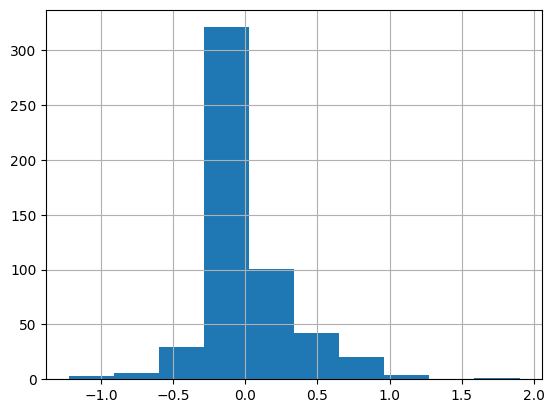

In [11]:
train_df.err.hist()

<AxesSubplot:>

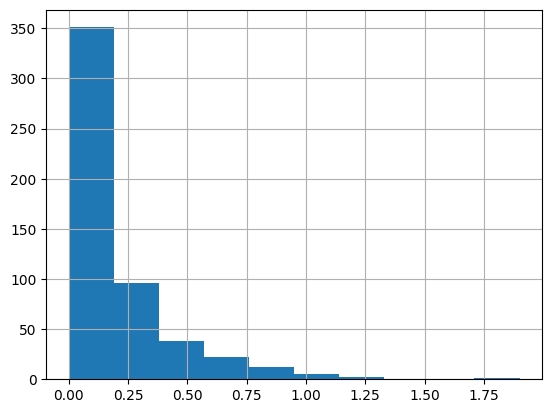

In [12]:
train_df.err_upd.hist()

In [13]:
train_df.err.nsmallest(5)

14    -1.223469
480   -0.994284
477   -0.979643
105   -0.857306
3     -0.805629
Name: err, dtype: float64

In [14]:
train_df.err.nlargest(5)

15     1.900066
504    1.206664
31     1.095802
29     1.009782
510    0.971327
Name: err, dtype: float64

In [15]:
train_df.sort_values(by ='err_upd', ascending = False, inplace = True)

In [16]:
train_df.head(20)

,image_name,distance,car_x_min,car_y_min,car_x_max,car_y_max,car_conf,car_class,car_h,car_w,...,plate_y_min,plate_x_max,plate_y_max,plate_w,plate_h,log_plate_w,log_plate_h,pred,err,err_upd
15,img_1621.jpg,7.37,1479.636719,1121.189331,2624.046875,2121.229248,0.887309,2.0,1000.039917,1144.410156,...,389.0,632.0,745.0,83.0,356.0,4.418841,5.874931,5.469934,1.900066,1.900066
14,img_1620.jpg,1.52,1318.691406,1117.102417,2259.526123,1941.014038,0.921435,2.0,823.911621,940.834717,...,330.0,511.0,619.0,62.0,289.0,4.127134,5.666427,2.743469,-1.223469,1.223469
504,img_2903.jpg,4.33,1392.530273,1182.834717,2279.583252,1880.715332,0.933908,2.0,697.880615,887.052979,...,314.0,451.0,612.0,65.0,298.0,4.174387,5.697093,3.123336,1.206664,1.206664
31,img_1653.jpg,6.44,1682.735352,1264.425171,2200.481934,1713.236328,0.869917,2.0,448.811157,517.746582,...,170.0,388.0,350.0,42.0,180.0,3.737670,5.192957,5.344198,1.095802,1.095802
29,img_1649.jpg,4.36,1647.646851,1207.656006,2378.687988,1831.277710,0.881632,2.0,623.621704,731.041138,...,232.0,574.0,496.0,63.0,264.0,4.143135,5.575949,3.350218,1.009782,1.009782
480,img_2862.jpg,2.10,1383.948486,1250.053101,2192.409424,1865.484985,0.937705,2.0,615.431885,808.460938,...,273.0,387.0,559.0,65.0,286.0,4.174387,5.655992,3.094284,-0.994284,0.994284
477,img_2858.jpg,0.85,574.717041,635.524597,3167.885986,2643.656738,0.855127,2.0,2008.132080,2593.168945,...,1457.0,1587.0,1847.0,186.0,390.0,5.225747,5.966147,1.829643,-0.979643,0.979643
510,img_2913.jpg,6.61,1659.582153,1239.397461,2132.143799,1629.581421,0.915403,2.0,390.183960,472.561646,...,161.0,238.0,319.0,38.0,158.0,3.637586,5.062595,5.638673,0.971327,0.971327
55,img_1700.jpg,5.00,1549.455933,1298.602783,2224.750000,1900.617188,0.916159,2.0,602.014404,675.294067,...,238.0,517.0,456.0,52.0,218.0,3.951244,5.384495,4.056180,0.943820,0.943820
25,img_1641.jpg,4.57,1564.113770,1260.328247,2319.003662,1915.875977,0.913652,2.0,655.547729,754.889893,...,263.0,304.0,513.0,59.0,250.0,4.077537,5.521461,3.634250,0.935750,0.935750


In [39]:
#plot_corrc(train_df, ['err'])

In [18]:
#plot_corrc(train_df, ['err_upd'])

Посмотрим на кадры с наибольшей (по модулю) ошибкой

In [34]:
for el in train_df.index[:5]:
    tmp = train_df.loc[el, :]
    
    img = open_img(os.path.join(DIR_DATA_TRAIN, tmp.image_name))

    #  рамка найденного автомобиля
    cv2.rectangle(img, 
                  (int(tmp.car_x_min), int(tmp.car_y_min)), 
                  (int(tmp.car_x_max), int(tmp.car_y_max)),
                  (255, 0, 0), 
                  6,
                 )

    sub_img = img[int(tmp.car_y_min) : int(tmp.car_y_max),
                  int(tmp.car_x_min) : int(tmp.car_x_max)
                 ]

    # рамка номера
    cv2.rectangle(sub_img, 
              (int(tmp.plate_y_min), int(tmp.plate_x_min)), 
              (int(tmp.plate_y_max), int(tmp.plate_x_max)),
              (255, 0, 0), 
              6,
             )
    

    img[int(tmp.car_y_min) : int(tmp.car_y_max),
        int(tmp.car_x_min) : int(tmp.car_x_max)
       ] = sub_img
    
    img = cv2.resize(img, [252*4, 252*3])

    cv2.imshow('bir error', img)
    #cv2.imshow('bir error', sub_img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

автомобили определяются верно.    
автомобильный номер с виду тоже.    

In [22]:
print("Notebook Runtime: %0.2f Minutes"%((time.time() - notebookstart)/60))

Notebook Runtime: 2.19 Minutes
